### Bot Detection using Digital DNA Compression

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

In [3]:
import random
import sys
import time
import zlib

In [4]:
from sklearn import utils
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, confusion_matrix

<hr>

### Digital DNA

Model account behaviour by defining the following alphabet, of cardinality N = 3,

$B^3_{type} = {\{A, C, T\}}$

A $\leftarrow$ tweet,

C $\leftarrow$ reply,

T $\leftarrow$ retweet

<hr>

#### Datasets

User profile data.

In [5]:
### Users

# Genuine accounts.
gen = pd.read_csv('./datasets_full/datasets_full.csv/genuine_accounts.csv/users.csv')

# Social spambots.
ss1 = pd.read_csv('./datasets_full/datasets_full.csv/social_spambots_1.csv/users.csv')
ss2 = pd.read_csv('./datasets_full/datasets_full.csv/social_spambots_2.csv/users.csv')
ss3 = pd.read_csv('./datasets_full/datasets_full.csv/social_spambots_3.csv/users.csv')

# Traditional spambots.
ts1 = pd.read_csv('./datasets_full/datasets_full.csv/traditional_spambots_1.csv/users.csv')
ts2 = pd.read_csv('./datasets_full/datasets_full.csv/traditional_spambots_2.csv/users.csv')
ts3 = pd.read_csv('./datasets_full/datasets_full.csv/traditional_spambots_3.csv/users.csv')
ts4 = pd.read_csv('./datasets_full/datasets_full.csv/traditional_spambots_4.csv/users.csv')

Tweets.

In [6]:
### Tweets

# Genuine accounts.
gen_tweets = pd.read_csv('./datasets_full/datasets_full.csv/genuine_accounts.csv/tweets.csv')

# Social spambots.
ss1_tweets = pd.read_csv('./datasets_full/datasets_full.csv/social_spambots_1.csv/tweets.csv')
ss2_tweets = pd.read_csv('./datasets_full/datasets_full.csv/social_spambots_2.csv/tweets.csv')
ss3_tweets = pd.read_csv('./datasets_full/datasets_full.csv/social_spambots_3.csv/tweets.csv')

# Traditional spambots.
ts1_tweets = pd.read_csv('./datasets_full/datasets_full.csv/traditional_spambots_1.csv/tweets.csv')

<hr>

#### Digital DNA.

In [7]:
def create_dna_from_tweets(tweets_df):
    '''For each user id in tweets_df return a digital DNA string based on posting behaviour.'''
    
    # Add columns for counts of tweets, replies and retweets.
    tweets_df['num_retweets'] = np.where(tweets_df['retweeted_status_id'] == 0, 0, 1)
    tweets_df['num_replies'] = np.where(tweets_df['in_reply_to_status_id'] == 0, 0, 1)
    tweets_df['num_tweets'] = np.where((tweets_df['num_retweets'] == 0) & (tweets_df['num_replies'] == 0), 1, 0)

    # DNA alphabet for tweet (A), retweet (C) and reply (T).
    tweets = tweets_df['num_tweets'] == 1
    retweets = tweets_df['num_retweets'] == 1
    replies = tweets_df['num_replies'] == 1

    tweets_df.loc[:, 'DNA'] = np.where(retweets, 'C', np.where(replies, 'T', 'A'))

    # Sort tweets by timestamp..
    tweets_df = tweets_df[['user_id', 'timestamp', 'DNA']]
    tweets_df = tweets_df.sort_values(by=['timestamp'])

    # Create digital DNA string for each user account.
    dna = tweets_df.groupby(by=['user_id'])['DNA'].agg(lambda x: ''.join(x))
    
    return dna

In [8]:
def compress_dna_df(dna):
    '''Return a dataframe with compression facts for a series of dna.'''

    # Convert DNA in string object to bytes object.
    dna_bytes = dna.apply(lambda s: s.encode('utf-8'))

    # Run compression on each DNA string in the sample.
    dna_compressed = dna_bytes.apply(lambda b: zlib.compress(b))

    # Create dataframe with compression facts.
    dna_df = pd.DataFrame({'dna': dna,
                           'original_dna_size': dna_bytes.apply(sys.getsizeof), 
                           'compressed_dna_size': dna_compressed.apply(sys.getsizeof)})
    
    dna_df['compression_ratio'] = dna_df['original_dna_size'] / dna_df['compressed_dna_size']
    
    return dna_df

In [9]:
def get_substring(s, max_seq_len=None, random_len=False):
    '''
    Return a substring no longer than max_seq_len chosen randomly from the string s.
    
    If length of s is smaller than max_seq_len, then the complete string s is returned.
    '''
    
    if max_seq_len is None:
        return s
    
    start = random.randint(0, max(1, len(s)-max_seq_len))
    end = min(len(s), start+max_seq_len)
    
    if random_len:
        end = min(end, start + random.randint(1, max_seq_len))
    
    return s[start:end]

Evaluation Metrics
1. Accuracy
1. Precision
1. Recall
1. F1 Score
1. Specificity
1. MCC

In [10]:
def evaluate(y_test, predictions):
    '''Return a dataframe with accuracy, precision, recall and f1 scores for predictions.'''
    
    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
    specificity = tn / (tn+fp)
    
    results = [
        {
            'Metric': 'Accuracy',
            'Score': accuracy_score(y_test, predictions)
        },
        {
            'Metric': 'Precision',
            'Score': precision_score(y_test, predictions)
        },
        {
            'Metric': 'Recall',
            'Score': recall_score(y_test, predictions)
        },
        {
            'Metric': 'F1 Score',
            'Score': f1_score(y_test, predictions)
        },
        {
            'Metric': 'MCC',
            'Score': matthews_corrcoef(y_test, predictions)
        },
        {
            'Metric': 'Specificity',
            'Score': specificity
        },
    ]

    return pd.DataFrame(results)

<hr>

In [11]:
def train_predict_evaluate(dna, features, test_size=0.5):
    '''Train a Logistic Regression model with given features
    using default parameters on a random sample of data.'''

    # Randomly shuffle the dna dataframe.
    dna = utils.shuffle(dna)

    # Features and labels.
    X = dna[features]
    y = dna.loc[:, 'label']

    # Split the dataset for training and testing using Logistic Regression.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

    # Logistic Regression classifier with default parameters.
    classifier = LogisticRegression()

    # Train the classifier.
    start_train = time.time()
    classifier.fit(X_train, y_train)
    end_train = time.time()

    # Make predictions on the test set.
    start_test = time.time()
    predictions = classifier.predict(X_test)
    end_test = time.time()

    # Evaluation on the test set.
    results = evaluate(y_test, predictions)

    return results

## Test Set #1

In [12]:
# Genuine accounts in test set 1.
gen_test1 = gen[gen['test_set_1'] == 1]

# Social spambots in test set 1.
ss1_test_1 = ss1[ss1['test_set_1'] == 1]


# Tweets for genuine accounts in test set 1.
gen_tweets_test1 = gen_tweets[gen_tweets['user_id'].isin(gen_test1['id'])]

# Tweets for spambot accounts in test set 1.
ss1_tweets_test1 = ss1_tweets[ss1_tweets['user_id'].isin(ss1_test_1['id'])]


# DNA for genuine accounts in test set 1.
gen_dna_test1 = create_dna_from_tweets(gen_tweets_test1)

# DNA for spambots in test set 1.
ss1_dna_test1 = create_dna_from_tweets(ss1_tweets_test1)

# Set empty string as DNA Sequence for accounts with no tweets in the dataset
gen_with_no_tweets_test1 = gen_test1[~gen_test1['id'].isin(gen_dna_test1.index)]
gen_with_no_tweets_dna_test1 = pd.Series(index=gen_with_no_tweets_test1['id']).replace(np.nan, '')

gen_dna_test1 = pd.concat([gen_dna_test1, gen_with_no_tweets_dna_test1])

## Test Set #2

In [13]:
# Genuine accounts in test set 2.
gen_test2 = gen[gen['test_set_2'] == 1]

# Social spambots in test set 2.
ss3_test_2 = ss3[ss3['test_set_2'] == 1]


# Tweets for genuine accounts in test set 2.
gen_tweets_test2 = gen_tweets[gen_tweets['user_id'].isin(gen_test2['id'])]

# Tweets for spambot accounts in test set 2.
ss3_tweets_test2 = ss3_tweets[ss3_tweets['user_id'].isin(ss3_test_2['id'])]


# DNA for genuine accounts in test set 2.
gen_dna_test2 = create_dna_from_tweets(gen_tweets_test2)

# DNA for spambots in test set 2.
ss3_dna_test2 = create_dna_from_tweets(ss3_tweets_test2)

# Set empty string as DNA Sequence for accounts with no tweets in the dataset
gen_with_no_tweets_test2 = gen_test2[~gen_test2['id'].isin(gen_dna_test2.index)]
gen_with_no_tweets_dna_test2 = pd.Series(index=gen_with_no_tweets_test2['id']).replace(np.nan, '')

gen_dna_test2 = pd.concat([gen_dna_test2, gen_with_no_tweets_dna_test2])

### Visualization for different values of maximum sequence length.

In [14]:
gen_dna = pd.concat([gen_dna_test1, gen_dna_test2])
bot_dna = pd.concat([ss1_dna_test1, ss3_dna_test2])

In [15]:
# Different values for max. length of the digital DNA sequence.
sequence_lengths = [10, 50, 100, 500, 1000, 2000]

# Dataframe to store compression stats for strings taken with different lengths.
all_dna = pd.DataFrame()

for seq_len in sequence_lengths:
    # DNA string of length seq_len for genuine accounts in test set 1.
    gen_dna_temp = gen_dna.apply(lambda s: get_substring(s, seq_len, random_len=True))
    
    # DNA string of length seq_len for social spambots in test set 1.
    bot_dna_temp = bot_dna.apply(lambda s: get_substring(s, seq_len, random_len=True))

    # DNA string compression for genuine accounts in test set 1.
    gen_dna_temp = compress_dna_df(gen_dna_temp)

    # DNA string compression for spambots in test set 1.
    bot_dna_temp = compress_dna_df(bot_dna_temp)
    
    # Add a column for label to the dataframes.
    gen_dna_temp['Account Type'] = 'Genuine'
    bot_dna_temp['Account Type'] = 'Bot'
    
    # Add a column for value of max sequence length.
    gen_dna_temp['Maximum Sequence Length'] = seq_len
    bot_dna_temp['Maximum Sequence Length'] = seq_len

    # Combine test set 1 accounts into a single dataframe.
    dna_temp = pd.concat([gen_dna_temp, bot_dna_temp])
    
    # Add the dataframe to the complete larger dataframe.
    all_dna = pd.concat([all_dna, dna_temp])

/Users/nivranshu/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


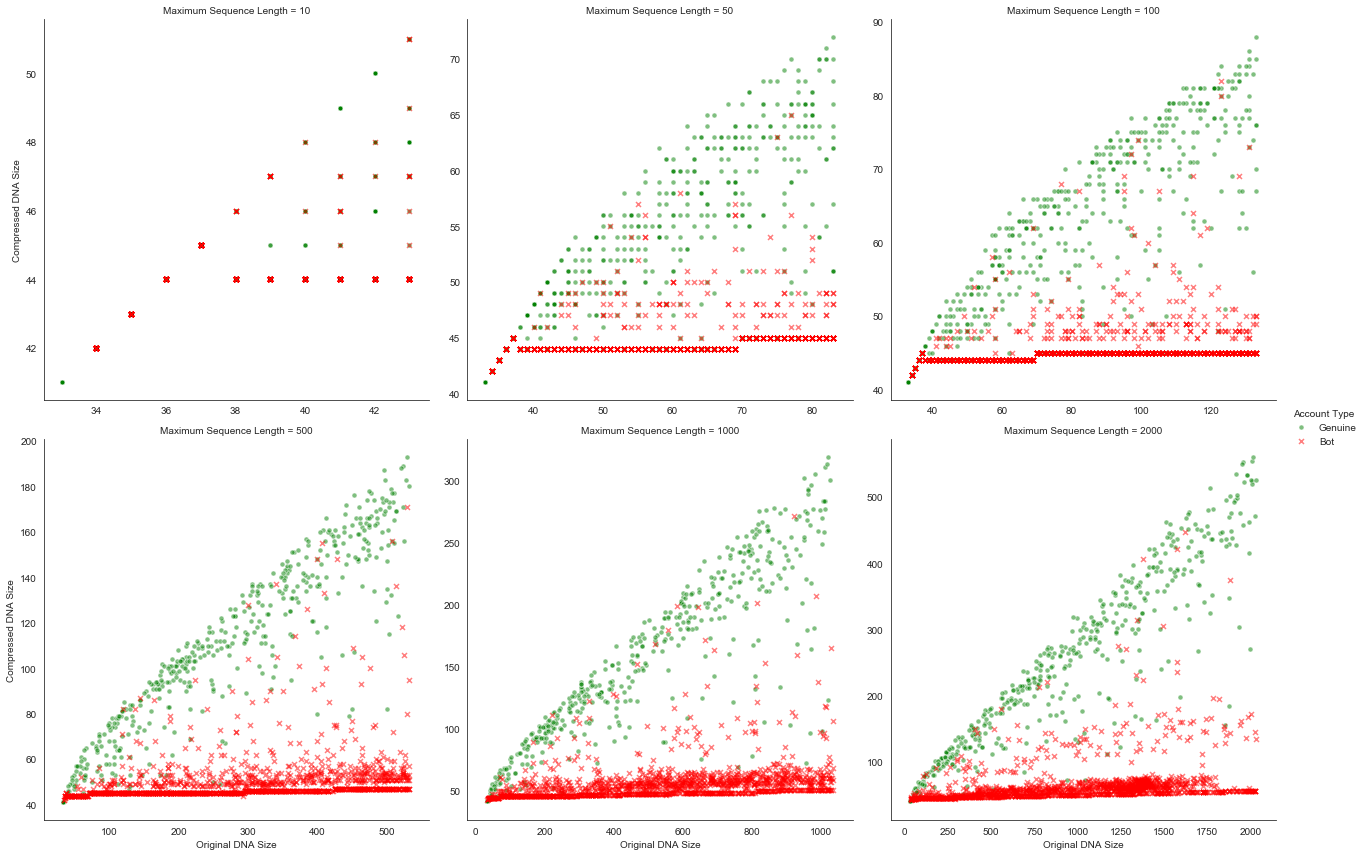

In [16]:
sns.set_style("white")

pal = {
    'Genuine': 'green',
    'Bot': 'red'
}

g = sns.FacetGrid(all_dna, col='Maximum Sequence Length', hue='Account Type', col_wrap=3,
                  palette=pal, size=6, hue_kws=dict(marker=["o", "x"]), sharex=False, sharey=False)
g.map(plt.scatter, "original_dna_size", "compressed_dna_size", s=25, alpha=.5, edgecolor="white")
g.add_legend()
g.set_axis_labels('Original DNA Size', 'Compressed DNA Size')

/Users/nivranshu/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


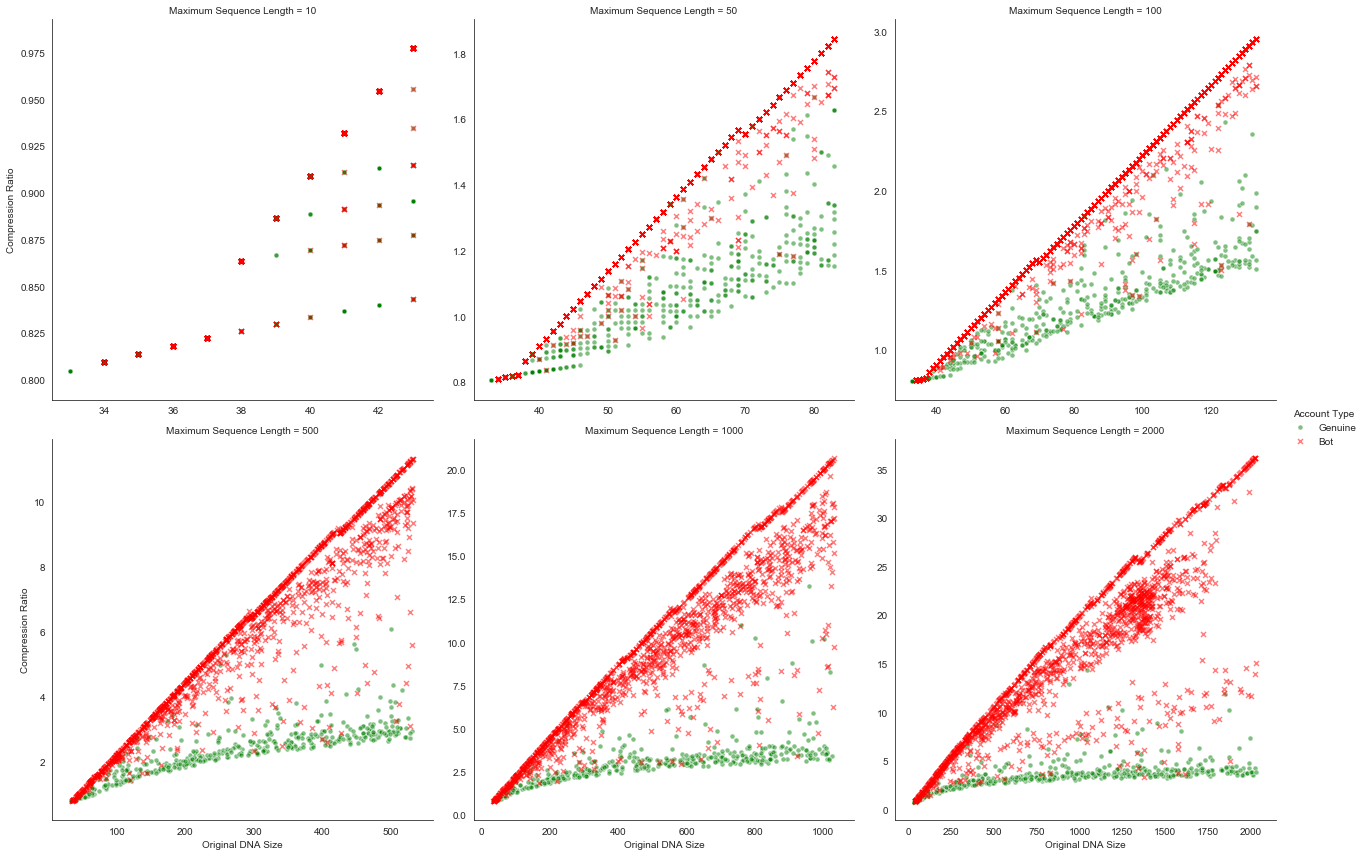

In [17]:
sns.set_style("white")

pal = {
    'Genuine': 'green',
    'Bot': 'red'
}

g = sns.FacetGrid(all_dna, col='Maximum Sequence Length', hue='Account Type', col_wrap=3,
                  palette=pal, size=6, hue_kws=dict(marker=["o", "x"]), sharex=False, sharey=False)
g.map(plt.scatter, "original_dna_size", "compression_ratio", s=25, alpha=.5, edgecolor="white")
g.add_legend()
g.set_axis_labels('Original DNA Size', 'Compression Ratio')

<hr>

## Test Set #1

In [18]:
# Different values for max. length of the digital DNA sequence.
sequence_lengths = [10, 25, 50, 100, 200, 500, 1000, 2000]

# Dataframe to store evaluation results with different sequence lengths.
results1 = pd.DataFrame()
results2 = pd.DataFrame()

for seq_len in sequence_lengths:
    # DNA string of length seq_len for genuine accounts in test set 1.
    gen_dna_temp = gen_dna_test1.apply(lambda s: get_substring(s, seq_len, random_len=True))
    
    # DNA string of length seq_len for social spambots in test set 1.
    bot_dna_temp = ss1_dna_test1.apply(lambda s: get_substring(s, seq_len, random_len=True))

    # DNA string compression for genuine accounts in test set 1.
    gen_dna_temp = compress_dna_df(gen_dna_temp)

    # DNA string compression for spambots in test set 1.
    bot_dna_temp = compress_dna_df(bot_dna_temp)
    
    # Add a column for label to the dataframes.
    gen_dna_temp['label'] = 0
    bot_dna_temp['label'] = 1
    
    # Combine test set 1 accounts into a single dataframe.
    dna_temp = pd.concat([gen_dna_temp, bot_dna_temp])
    
    # Evaluate logistic regression classifier.
    res_by_seq_len1 = pd.DataFrame()
    res_by_seq_len2 = pd.DataFrame()
    
    for _ in range(100):
        res_by_seq_len1 = pd.concat([res_by_seq_len1, 
                                   train_predict_evaluate(dna_temp, 
                                                          ['original_dna_size', 
                                                           'compressed_dna_size'])])
        res_by_seq_len2 = pd.concat([res_by_seq_len2, 
                                   train_predict_evaluate(dna_temp, 
                                                          ['original_dna_size', 
                                                           'compression_ratio'])])

    res_by_seq_len1 = res_by_seq_len1.groupby(by=['Metric']) \
       .mean() \
       .rename({'Score': 'Mean'}, axis=1) \
       .join(res_by_seq_len1.groupby(by=['Metric']) \
                    .std() \
                    .rename({'Score': 'Std.'}, axis=1))
    
    res_by_seq_len2 = res_by_seq_len2.groupby(by=['Metric']) \
       .mean() \
       .rename({'Score': 'Mean'}, axis=1) \
       .join(res_by_seq_len2.groupby(by=['Metric']) \
                    .std() \
                    .rename({'Score': 'Std.'}, axis=1))
    
    res_by_seq_len1['Maximum Sequence Length'] = seq_len
    res_by_seq_len2['Maximum Sequence Length'] = seq_len
    
    results1 = pd.concat([results1, res_by_seq_len1])
    results2 = pd.concat([results2, res_by_seq_len2])

results1 = results1.reset_index()
results2 = results2.reset_index()

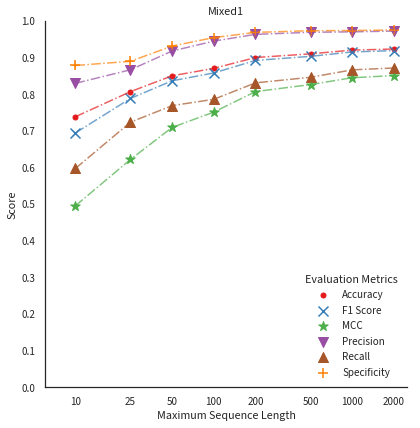

In [19]:
sns.set(style='white', font='Source Sans Pro')

palette = sns.color_palette('Set1')[:4] + [sns.color_palette('Set1')[6]] + [sns.color_palette('Set1')[4]]

g = sns.FacetGrid(results1, hue='Metric', height=6,
                  hue_kws=dict(marker=[".", "x", "*", "v", "^", "+"]), 
                  palette=palette)

g.map(plt.scatter, "Maximum Sequence Length", "Mean", s=100)
g.map(plt.plot, "Maximum Sequence Length", "Mean", linestyle='-.', alpha=0.7)

g.set(ylim=(0, 1), xlim=(6, 2500), xscale="log")

g.ax.set_xticks([10, 25, 50, 100, 200, 500, 1000, 2000])
g.ax.set_yticks(np.round(np.arange(0, 1.1, 0.1), 2))

g.ax.set_xticklabels([10, 25, 50, 100, 200, 500, 1000, 2000])
g.ax.set_yticklabels(np.round(np.arange(0, 1.1, 0.1), 2))

g.ax.set_xlabel("Maximum Sequence Length")
g.ax.set_ylabel("Score")

g.ax.set_title('Mixed1')

plt.legend(handles=g.ax.get_legend_handles_labels()[0][6:], 
           title='Evaluation Metrics', 
           loc='lower right', frameon=False)

plt.savefig('dna-len-1.pdf')

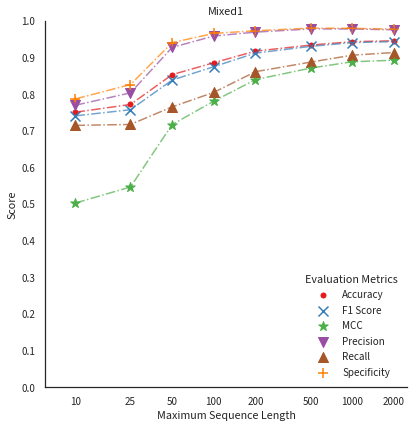

In [20]:
sns.set(style='white', font='Source Sans Pro')

palette = sns.color_palette('Set1')[:4] + [sns.color_palette('Set1')[6]] + [sns.color_palette('Set1')[4]]

g = sns.FacetGrid(results2, hue='Metric', height=6,
                  hue_kws=dict(marker=[".", "x", "*", "v", "^", "+"]), 
                  palette=palette)

g.map(plt.scatter, "Maximum Sequence Length", "Mean", s=100)
g.map(plt.plot, "Maximum Sequence Length", "Mean", linestyle='-.', alpha=0.7)

g.set(ylim=(0, 1), xlim=(6, 2500), xscale="log")

g.ax.set_xticks([10, 25, 50, 100, 200, 500, 1000, 2000])
g.ax.set_yticks(np.round(np.arange(0, 1.1, 0.1), 2))

g.ax.set_xticklabels([10, 25, 50, 100, 200, 500, 1000, 2000])
g.ax.set_yticklabels(np.round(np.arange(0, 1.1, 0.1), 2))

g.ax.set_xlabel("Maximum Sequence Length")
g.ax.set_ylabel("Score")

g.ax.set_title('Mixed1')

plt.legend(handles=g.ax.get_legend_handles_labels()[0][6:], 
           title='Evaluation Metrics', 
           loc='lower right', frameon=False)

plt.savefig('dna-len-1.pdf')

## Test Set #2

In [21]:
# Different values for max. length of the digital DNA sequence.
sequence_lengths = [10, 25, 50, 100, 200, 500, 1000, 2000]

# Dataframe to store evaluation results with different sequence lengths.
results1 = pd.DataFrame()
results2 = pd.DataFrame()

for seq_len in sequence_lengths:
    # DNA string of length seq_len for genuine accounts in test set 1.
    gen_dna_temp = gen_dna_test2.apply(lambda s: get_substring(s, seq_len, random_len=True))
    
    # DNA string of length seq_len for social spambots in test set 1.
    bot_dna_temp = ss3_dna_test2.apply(lambda s: get_substring(s, seq_len, random_len=True))

    # DNA string compression for genuine accounts in test set 1.
    gen_dna_temp = compress_dna_df(gen_dna_temp)

    # DNA string compression for spambots in test set 1.
    bot_dna_temp = compress_dna_df(bot_dna_temp)
    
    # Add a column for label to the dataframes.
    gen_dna_temp['label'] = 0
    bot_dna_temp['label'] = 1
    
    # Combine test set 1 accounts into a single dataframe.
    dna_temp = pd.concat([gen_dna_temp, bot_dna_temp])
    
    # Evaluate logistic regression classifier.
    res_by_seq_len1 = pd.DataFrame()
    res_by_seq_len2 = pd.DataFrame()
    
    for i in range(100):
        np.random.seed(i)
        res_by_seq_len1 = pd.concat([res_by_seq_len1, 
                                   train_predict_evaluate(dna_temp, 
                                                          ['original_dna_size', 
                                                           'compressed_dna_size'])])
        np.random.seed(i)
        res_by_seq_len2 = pd.concat([res_by_seq_len2, 
                                   train_predict_evaluate(dna_temp, 
                                                          ['original_dna_size', 
                                                           'compression_ratio'])])

    res_by_seq_len1 = res_by_seq_len1.groupby(by=['Metric']) \
       .mean() \
       .rename({'Score': 'Mean'}, axis=1) \
       .join(res_by_seq_len1.groupby(by=['Metric']) \
                    .std() \
                    .rename({'Score': 'Std.'}, axis=1))
    
    res_by_seq_len2 = res_by_seq_len2.groupby(by=['Metric']) \
       .mean() \
       .rename({'Score': 'Mean'}, axis=1) \
       .join(res_by_seq_len2.groupby(by=['Metric']) \
                    .std() \
                    .rename({'Score': 'Std.'}, axis=1))
    
    res_by_seq_len1['Maximum Sequence Length'] = seq_len
    res_by_seq_len2['Maximum Sequence Length'] = seq_len
    
    results1 = pd.concat([results1, res_by_seq_len1])
    results2 = pd.concat([results2, res_by_seq_len2])

results1 = results1.reset_index()
results2 = results2.reset_index()

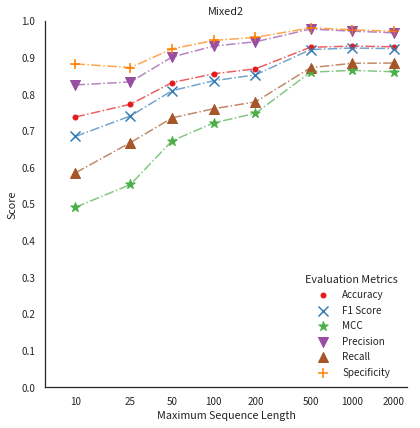

In [22]:
sns.set(style='white', font='Source Sans Pro')

palette = sns.color_palette('Set1')[:4] + [sns.color_palette('Set1')[6]] + [sns.color_palette('Set1')[4]]

g = sns.FacetGrid(results1, hue='Metric', height=6,
                  hue_kws=dict(marker=[".", "x", "*", "v", "^", "+"]), 
                  palette=palette)

g.map(plt.scatter, "Maximum Sequence Length", "Mean", s=100)
g.map(plt.plot, "Maximum Sequence Length", "Mean", linestyle='-.', alpha=0.7)

g.set(ylim=(0, 1), xlim=(6, 2500), xscale="log")

g.ax.set_xticks([10, 25, 50, 100, 200, 500, 1000, 2000])
g.ax.set_yticks(np.round(np.arange(0, 1.1, 0.1), 2))

g.ax.set_xticklabels([10, 25, 50, 100, 200, 500, 1000, 2000])
g.ax.set_yticklabels(np.round(np.arange(0, 1.1, 0.1), 2))

g.ax.set_xlabel("Maximum Sequence Length")
g.ax.set_ylabel("Score")

g.ax.set_title('Mixed2')

plt.legend(handles=g.ax.get_legend_handles_labels()[0][6:], 
           title='Evaluation Metrics', 
           loc='lower right', frameon=False)

plt.savefig('dna-len-2.pdf')

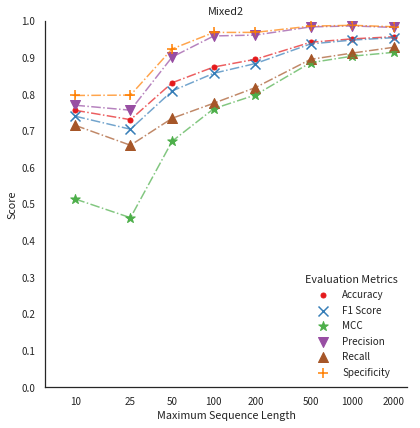

In [23]:
sns.set(style='white', font='Source Sans Pro')

palette = sns.color_palette('Set1')[:4] + [sns.color_palette('Set1')[6]] + [sns.color_palette('Set1')[4]]

g = sns.FacetGrid(results2, hue='Metric', height=6,
                  hue_kws=dict(marker=[".", "x", "*", "v", "^", "+"]), 
                  palette=palette)

g.map(plt.scatter, "Maximum Sequence Length", "Mean", s=100)
g.map(plt.plot, "Maximum Sequence Length", "Mean", linestyle='-.', alpha=0.7)

g.set(ylim=(0, 1), xlim=(6, 2500), xscale="log")

g.ax.set_xticks([10, 25, 50, 100, 200, 500, 1000, 2000])
g.ax.set_yticks(np.round(np.arange(0, 1.1, 0.1), 2))

g.ax.set_xticklabels([10, 25, 50, 100, 200, 500, 1000, 2000])
g.ax.set_yticklabels(np.round(np.arange(0, 1.1, 0.1), 2))

g.ax.set_xlabel("Maximum Sequence Length")
g.ax.set_ylabel("Score")

g.ax.set_title('Mixed2')

plt.legend(handles=g.ax.get_legend_handles_labels()[0][6:], 
           title='Evaluation Metrics', 
           loc='lower right', frameon=False)

plt.savefig('dna-len-2.pdf')